In [1]:
# 任务: 通过神经网络从原始数据中发现因子, 并拟合模型
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

In [2]:
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price  
datetime   instrument                                               
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322  
...                        ...        ...          ...         ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486  
           688561.SH    0.4736   22567.89  149379.0770   66.190981  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  
           688981.SH    0.6114   60396.11  248594.8820   41.160744  

[1199445 rows x 10 columns]

In [3]:
# 构造目标值, 并按照-10% 和10%截断(因为有涨跌停限制)
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 100
df = df.dropna()
df["label"].clip(-0.1, 0.1, inplace=True) 
df["label"].describe()

count    1.197673e+06
mean     5.829445e-04
std      2.843395e-02
min     -1.000000e-01
25%     -1.330000e-02
50%      0.000000e+00
75%      1.370000e-02
max      1.000000e-01
Name: label, dtype: float64

In [4]:
kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
    "groupby": "instrument"
}
X = alpha.alpha360(kwargs=kwargs)
X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()
X

open1     open2     open3     open4     open5  \
datetime   instrument                                                     
2006-04-07 000001.SZ   1.024730  1.015456  0.990726  0.976816  0.973725   
           000002.SZ   1.023426  0.995608  1.010249  0.959004  0.951684   
           000059.SZ   0.955711  0.960373  0.958042  0.930070  0.923077   
           000061.SZ   0.876122  0.829443  0.829443  0.800718  0.804309   
           000063.SZ   1.013342  0.987929  1.012706  0.972363  0.959339   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.963159  0.955070  0.951026  0.914111  0.904552   
           688396.SH   0.999434  0.990377  1.000000  1.015094  1.023019   
           688561.SH   1.024219  1.031379  0.938157  0.938309  0.941356   
           688599.SH   0.942443  0.863839  0.873565  0.858099  0.874043   
           688981.SH   1.011980  1.000000  1.000000  1.015892  1.020293   

                          open6     open7     open8     open9    open10  ...  \
datetime   instrument                                                    ...   
2006-04-07 000001.SZ   1.003091  0.989181  0.981453  0.975270  0.989181  ...   
           000002.SZ   0.966325  0.959004  0.913616  0.868228  0.878477  ...   
           000059.SZ   0.932401  0.951049  0.953380  0.934732  0.946387  ...   
           000061.SZ   0.825853  0.798923  0.771993  0.777379  0.789946  ...   
           000063.SZ   0.945044  0.930432  0.932338  0.927573  0.921220  ...   
...                         ...       ...       ...       ...       ...  ...   
2022-12-28 688363.SH   0.919921  0.941246  0.932642  0.956688  0.919185  ...   
           688396.SH   1.024717  1.074528  1.065660  1.068679  1.107547  ...   
           688561.SH   0.974867  0.982635  1.002285  0.990251  0.967251  ...   
           688599.SH   0.882175  0.872449  0.883291  0.876276  0.893973  ...   
           688981.SH   1.016626  1.046455  1.039120  1.038142  1.074817  ...   

                       amount52  amount53  amount54  amount55  amount56  \
datetime   instrument                                                     
2006-04-07 000001.SZ   0.077210  0.064337  0.054171  0.078648  0.173116   
           000002.SZ   0.070373  0.070449  0.048691  0.052976  0.060270   
           000059.SZ   0.027743  0.033839  0.035324  0.057521  0.094596   
           000061.SZ   0.016100  0.009716  0.011192  0.020518  0.017056   
           000063.SZ   0.028738  0.026976  0.039886  0.038801  0.028084   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.042483  0.057178  0.039490  0.037668  0.033272   
           688396.SH   0.155135  0.171983  0.122359  0.175270  0.108399   
           688561.SH   0.156938  0.092316  0.139302  0.078257  0.056223   
           688599.SH   0.155566  0.213565  0.126343  0.091361  0.053551   
           688981.SH   0.180326  0.226451  0.164799  0.154050  0.157421   

                       amount57  amount58  amount59  amount60     label  
datetime   instrument                                                    
2006-04-07 000001.SZ   0.090984  0.198515  0.125080  0.125308  0.026700  
           000002.SZ   0.050402  0.059178  0.054714  0.049890  0.025300  
           000059.SZ   0.063895  0.142202  0.058425  0.019139 -0.020700  
           000061.SZ   0.030299  0.029542  0.020071  0.046194 -0.001800  
           000063.SZ   0.062820  0.054851  0.046420  0.059121 -0.007900  
...                         ...       ...       ...       ...       ...  
2022-12-28 688363.SH   0.051896  0.032411  0.042411  0.042831 -0.001550  
           688396.SH   0.249247  0.183622  0.158856  0.164713 -0.004161  
           688561.SH   0.083808  0.063439  0.081799  0.104741  0.004736  
           688599.SH   0.071348  0.070434  0.057827  0.057153  0.008861  
           688981.SH   0.178280  0.091555  0.100307  0.087161  0.006114  

[1144849 rows x 361 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 863009 entries, (Timestamp('2006-04-07 00:00:00'), '000001.SZ') to (Timestamp('2018-12-28 00:00:00'), '603993.SH')
Columns: 361 entries, open1 to label
dtypes: float64(361)
memory usage: 2.3+ GB
None
X_mis= 0.0
clean dataset done 

split data done 

label norm done 



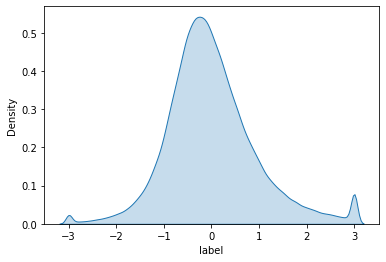

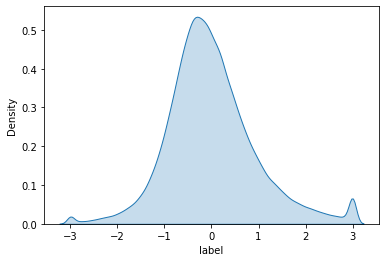

norm data done 

all works done 



In [5]:
# 按时间划分出训练集和测试集
X_train = X[X.index.get_level_values(0) <= "2018-12-31"]
X_test = X[X.index.get_level_values(0) >= "2019-01-01"]

# 从训练集中按7：3的比例随机拆分出验证集, 并在截面上进行标准化
result = q.auto_process(X_train, "label", groupby="instrument", datetime="datetime", 
                        split_params={"method": "split", "params": {"test": 0.3}}, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_test"], result["y_test"]

# 处理测试集
y_test = X_test.pop("label")
x_mean, x_std = X_test.groupby("datetime").mean(), X_test.groupby("datetime").std()
X_test = q.zscorenorm(X_test, x_mean, x_std)

y_mean = y_test.groupby("instrument").shift(2).groupby("datetime").mean()
y_std = y_test.groupby("instrument").shift(2).groupby("datetime").std()
y_mean.fillna(0.0002, inplace=True)  # 假设年化5%, 则每天应为0.0002
y_std.fillna(0.0189, inplace=True)  # 假设年化波动率为30%, 即0.3, 则每天的波动率应为0.0189

X_test = X_test.groupby("instrument").fillna(method="ffill").dropna()
y_test = y_test[y_test.index.isin(X_test.index)]

In [6]:
from tensorflow.keras import layers, models, optimizers, metrics, regularizers

rmse = metrics.RootMeanSquaredError(name="rmse")
model = models.Sequential([
    # 第一层: 相当于将原始数据换了一组基，得到新的360个特征, 每个新特征由所有原始特征的线性函数和一个非线性函数swish()合成
    layers.Dense(360, activation='swish', use_bias=False),  
    
    # 第二、三层: # 使用新的数据合成因子, 使用swish函数过滤噪声, 并进行正则化
    layers.Dense(1024, activation='swish', use_bias=False, kernel_regularizer=regularizers.l2(0.002)),  
    layers.Dense(1024, activation='swish', use_bias=False, kernel_regularizer=regularizers.l2(0.002)),  
    layers.LayerNormalization(),  # 因子标准化
    
    # 第四层: y_hat = W * X + b(岭回归, 加入了l2正则), W是因子收益率, X为因子, b即alpha收益(不随因子变化而变化)
    layers.Dense(1, kernel_regularizer=regularizers.l2(0.002))  
])
model.compile(optimizer=optimizers.Adam(0.0003), loss=metrics.mean_squared_error, metrics=[rmse, 'mae'])
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=128, epochs=20, verbose=1)

Epoch 1/20
4720/4720 [==============================] - 150s 32ms/step - loss: 2.1072 - rmse: 0.9646 - mae: 0.7206 - val_loss: 1.0247 - val_rmse: 0.9496 - val_mae: 0.7136
Epoch 2/20
4720/4720 [==============================] - 150s 32ms/step - loss: 0.9201 - rmse: 0.9441 - mae: 0.7057 - val_loss: 0.9136 - val_rmse: 0.9529 - val_mae: 0.7225
Epoch 3/20
4720/4720 [==============================] - 151s 32ms/step - loss: 0.8924 - rmse: 0.9426 - mae: 0.7041 - val_loss: 0.9028 - val_rmse: 0.9490 - val_mae: 0.7118
Epoch 4/20
4720/4720 [==============================] - 151s 32ms/step - loss: 0.8903 - rmse: 0.9422 - mae: 0.7037 - val_loss: 0.9016 - val_rmse: 0.9487 - val_mae: 0.7093
Epoch 5/20
4720/4720 [==============================] - 151s 32ms/step - loss: 0.8891 - rmse: 0.9418 - mae: 0.7034 - val_loss: 0.9046 - val_rmse: 0.9500 - val_mae: 0.7157
Epoch 6/20
4720/4720 [==============================] - 151s 32ms/step - loss: 0.8890 - rmse: 0.9418 - mae: 0.7035 - val_loss: 0.9026 - val_rmse:

In [7]:
pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

8808/8808 [==============================] - 34s 4ms/step


,predict
count,281840.000000
mean,-0.000630
std,0.001736
min,-0.012391
25%,-0.001663
50%,-0.000421
75%,0.000591
max,0.005557


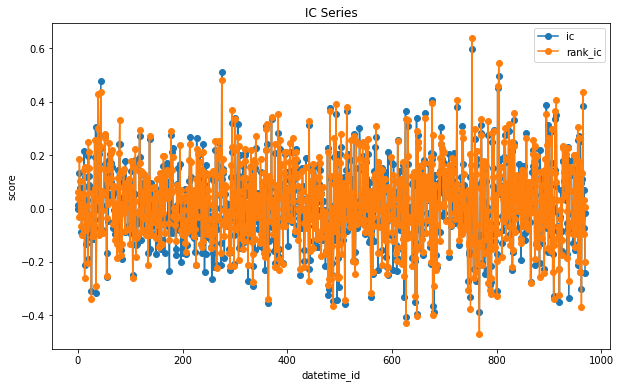

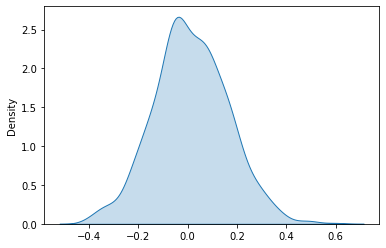

ic= 0.012606143768738934 icir= 0.08370142060559173 rank_ic= 0.023351554969005497 rank_icir= 0.15274621104917196


0.01599557892816453

In [8]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred.values, y_test)
r[0]

In [9]:
# 将预测值处理成回测需要的格式
df_test = df[df.index.get_level_values(0) >= "2019-01-01"]
pred = executor.prepare(pred, df_test, price='close', volume='vol')
pred

predict   price     volume
time       code                                  
2019-01-02 000001.SZ  0.000448    9.28  539386.32
           000002.SZ -0.002813   24.07  247010.28
           000063.SZ -0.002191   18.78  649682.72
           000069.SZ -0.001832    5.98  403924.79
           000100.SZ -0.002033    2.53  890514.27
...                        ...     ...        ...
2022-12-27 688363.SH -0.003056  135.99   67620.51
           688396.SH -0.000538   53.00   22894.05
           688561.SH -0.002892   65.65   17585.16
           688599.SH -0.003087   62.72  170829.80
           688981.SH  0.000151   40.90   61293.26

[281386 rows x 3 columns]

Accuracy of Prediction: 0.5283347430220409


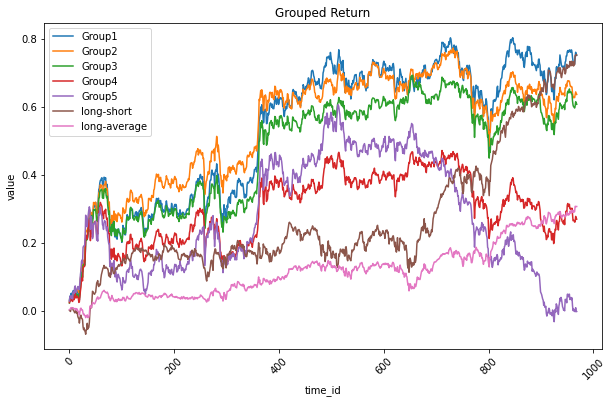

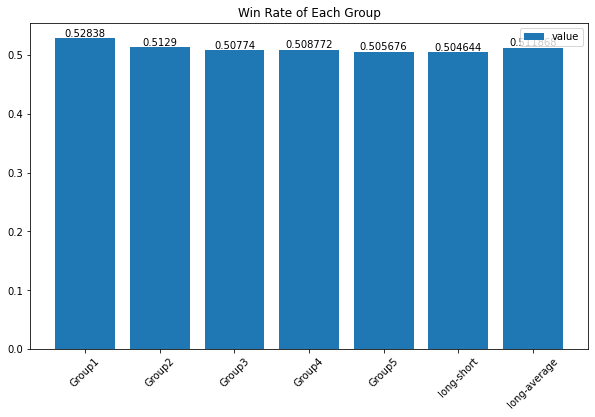

In [10]:
report.group_return_ana(pred, y_test)

In [16]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%且值大于0.5%的股票, 做空后20%且值小于0.5%的股票. 自动平仓
        "kwargs": {
            "sigma": 1,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.5  # 手数随可用资金而改变，最大不会超过股票当天成交量的0.2%(例如T+1时下单，下单手数不会超过T时成交量的0.2%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

E(r): 0.4249638428409484
std: 0.2010470353570923
E(r_benchmark): 0.42080158710526333
std_benchmark: 0.17399760139183215 

Cumulative Rate of Return: 0.30479857244217157
Cumulative Rate of Return(benchmark): 0.3452639230000001
Cumulative Excess Rate of Return: -0.04046535055782852 

Max Drawdown: -0.6311830080051093
Max Drawdown(benchmark): -0.541086994 

Sharpe Ratio: 2.113344523113546
Sortino Ratio: 0.026338691630329564
Information Ratio: 0.020702895361238365 

Beta: 1.131045644572473
Profitable Days(%): 0.5263157894736842


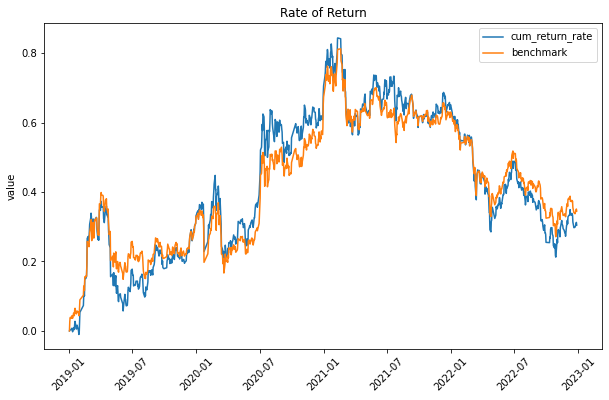

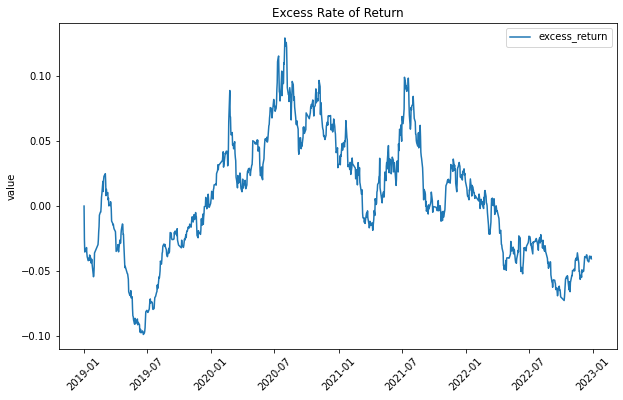

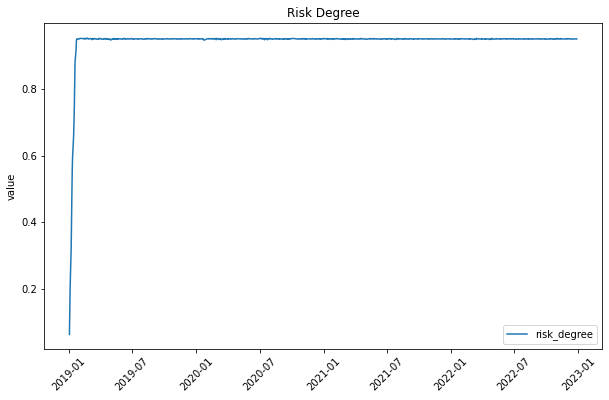

In [17]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [13]:
model.save("dnn")

INFO:tensorflow:Assets written to: dnn\assets


INFO:tensorflow:Assets written to: dnn\assets
